In [1]:
import os.path
import keras.applications.mobilenet
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import PIL.Image
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/stanislav/Documents/notebooks/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stanislav/Documents/notebooks/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stanislav/Documents/notebooks/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
DATA_ROOT = os.path.expanduser("~/Documents/data/")
BATCH_SIZE = 8
STEPS_PER_EPOCH = 100
SIZE = 128

## The model

We experiment with the model inspired by [keras.io](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes).  It comprises a dense layer on top of a MobileNet and an optional dropout.

In [3]:
def new_model(dropout=0, n=1024, pooling='avg'):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3), pooling=pooling)
    x = base_model.output
    x = Dense(n, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=x)

Training

In [4]:
def train(model, data_gen, directory, layer_count = None, params={},
          epochs=4, validation_directory=None, validation_generator=None):

    if layer_count == None:
        layer_count = len(model.layers)

    for layer in model.layers[: -layer_count]:
        layer.trainable = False

    for layer in model.layers[-layer_count:]:
        layer.trainable = True

    gen = data_gen.flow_from_directory(directory,
                                       class_mode='binary',
                                       target_size=(SIZE, SIZE), 
                                       batch_size=BATCH_SIZE)

    if validation_generator:
        val_gen = validation_generator.flow_from_directory(validation_directory,
                                                    class_mode='binary',
                                                           target_size=(SIZE, SIZE), 
                                                          batch_size=BATCH_SIZE)
    else:
        val_gen = None

    model.compile(**params)
    history = model.fit_generator(gen,
                        epochs=epochs,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_gen)
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [5]:
def dense_params1():
    return {'optimizer': 'rmsprop',
               'loss': 'binary_crossentropy',
               'metrics': ['accuracy']}

In [6]:
def base_params1():
    return {'optimizer': SGD(lr=0.0001, momentum=0.9),
              'loss': 'binary_crossentropy',
              'metrics': ['accuracy']}

In [7]:

def dense_params2(lr=0.001, decay=0.0):
    return {'optimizer': Adam(decay=decay, lr=lr),
               'loss': 'binary_crossentropy',
               'metrics': ['accuracy']}
def base_params2(lr=0.0001):
    return {'optimizer': Adam(lr=lr),
              'loss': 'binary_crossentropy',
              'metrics': ['accuracy']}

In [8]:
dg_train = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
dg_val = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

In [9]:
model1 = new_model(dropout=0, n=1024, pooling='avg')
model1.summary()








Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)      

## Model 1: no dropout

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/4
100/100 [==============================] - 14s 140ms/step - loss: 0.8942 - acc: 0.8213 - val_loss: 0.1094 - val_acc: 0.9525
Epoch 2/4
100/100 [==============================] - 13s 132ms/step - loss: 0.3389 - acc: 0.8825 - val_loss: 0.2334 - val_acc: 0.9113
Epoch 3/4
100/100 [==============================] - 13s 127ms/step - loss: 0.3665 - acc: 0.8713 - val_loss: 0.0527 - val_acc: 0.9750
Epoch 4/4
100/100 [==============================] - 13s 129ms/step - loss: 0.3108 - acc: 0.8888 - val_loss: 0.3152 - val_acc: 0.9025


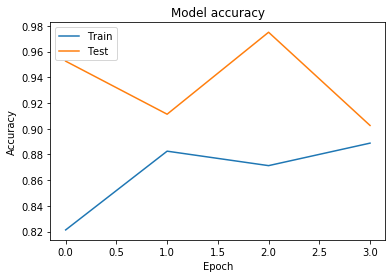

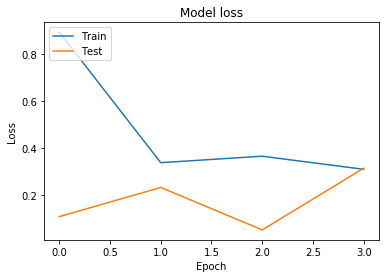

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 16s 161ms/step - loss: 0.4119 - acc: 0.8625 - val_loss: 0.0723 - val_acc: 0.9700
Epoch 2/4
100/100 [==============================] - 16s 162ms/step - loss: 0.2095 - acc: 0.9213 - val_loss: 0.0660 - val_acc: 0.9725
Epoch 3/4
100/100 [==============================] - 15s 154ms/step - loss: 0.1825 - acc: 0.9262 - val_loss: 0.0650 - val_acc: 0.9738
Epoch 4/4
100/100 [==============================] - 17s 167ms/step - loss: 0.1923 - acc: 0.9163 - val_loss: 0.0651 - val_acc: 0.9712


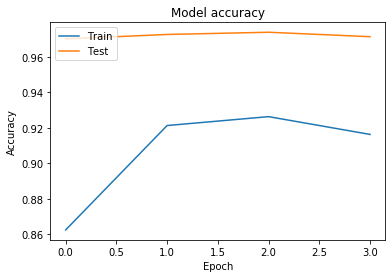

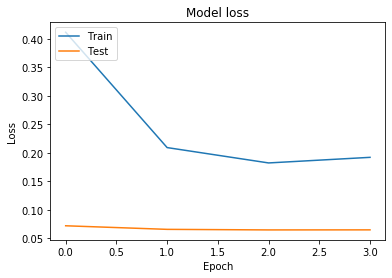

In [10]:
train(model1, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params1(),
      epochs=4,
      layer_count = 3,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model1, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params1(),
      epochs=4,
      layer_count = 20,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))

## Model 2
Change RMSprop to Adam.  The latter is used in future models.

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 14s 140ms/step - loss: 0.4886 - acc: 0.7738 - val_loss: 0.2514 - val_acc: 0.9237
Epoch 2/4
100/100 [==============================] - 13s 129ms/step - loss: 0.3254 - acc: 0.8762 - val_loss: 0.1849 - val_acc: 0.9350
Epoch 3/4
100/100 [==============================] - 14s 140ms/step - loss: 0.2886 - acc: 0.8725 - val_loss: 0.1384 - val_acc: 0.9487
Epoch 4/4
100/100 [==============================] - 15s 146ms/step - loss: 0.2453 - acc: 0.8925 - val_loss: 0.1197 - val_acc: 0.9537


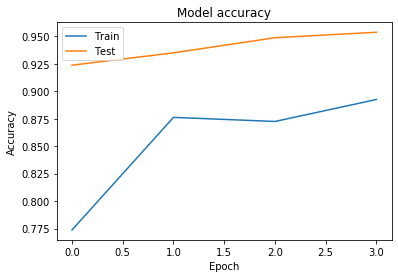

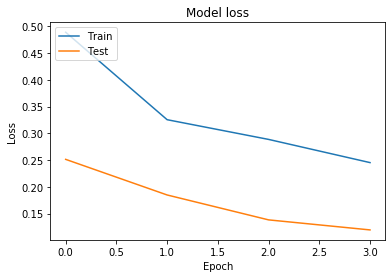

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 18s 181ms/step - loss: 0.2373 - acc: 0.8962 - val_loss: 0.1060 - val_acc: 0.9625
Epoch 2/4
100/100 [==============================] - 16s 165ms/step - loss: 0.1854 - acc: 0.9287 - val_loss: 0.2307 - val_acc: 0.9000
Epoch 3/4
100/100 [==============================] - 17s 168ms/step - loss: 0.2486 - acc: 0.8950 - val_loss: 0.1536 - val_acc: 0.9400
Epoch 4/4
100/100 [==============================] - 16s 164ms/step - loss: 0.1774 - acc: 0.9287 - val_loss: 0.0702 - val_acc: 0.9738


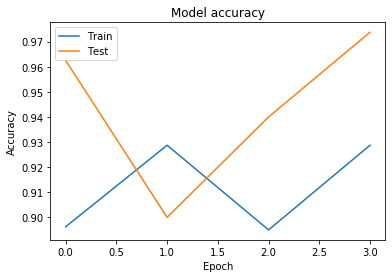

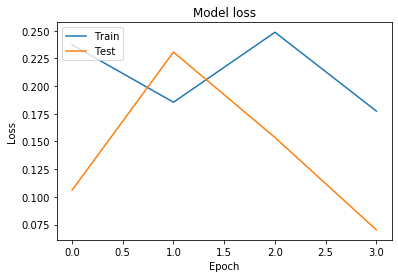

In [11]:
model2 = new_model(dropout=0, n=1024, pooling='avg')
train(model2, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params2(),
      layer_count=2,
      epochs=4,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model2, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params2(),
      layer_count=19,
      epochs=4,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))

## Model 3
Trying max pooling instead of average pooling.  At least this requires smaller learning rate.  Anyway, the results are poor, so we stick with the avg pooling for a while.

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 14s 144ms/step - loss: 0.8361 - acc: 0.6175 - val_loss: 0.8085 - val_acc: 0.6575
Epoch 2/4
100/100 [==============================] - 13s 135ms/step - loss: 0.6980 - acc: 0.6613 - val_loss: 0.6251 - val_acc: 0.7125
Epoch 3/4
100/100 [==============================] - 13s 131ms/step - loss: 0.6049 - acc: 0.7288 - val_loss: 0.5671 - val_acc: 0.7438
Epoch 4/4
100/100 [==============================] - 14s 138ms/step - loss: 0.5551 - acc: 0.7450 - val_loss: 0.5431 - val_acc: 0.7575


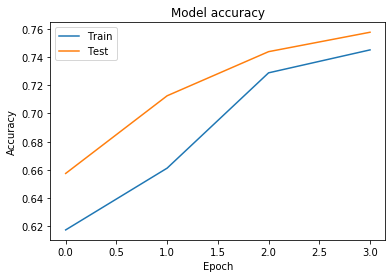

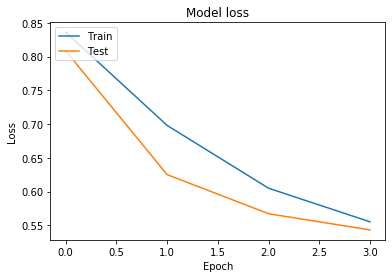

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/6
100/100 [==============================] - 18s 183ms/step - loss: 0.4511 - acc: 0.7837 - val_loss: 0.2366 - val_acc: 0.8950
Epoch 2/6
100/100 [==============================] - 17s 167ms/step - loss: 0.3463 - acc: 0.8612 - val_loss: 0.1893 - val_acc: 0.9187
Epoch 3/6
100/100 [==============================] - 16s 163ms/step - loss: 0.2511 - acc: 0.8988 - val_loss: 0.1587 - val_acc: 0.9313
Epoch 4/6
100/100 [==============================] - 17s 172ms/step - loss: 0.3002 - acc: 0.8700 - val_loss: 0.1567 - val_acc: 0.9263
Epoch 5/6
100/100 [==============================] - 16s 164ms/step - loss: 0.2910 - acc: 0.8800 - val_loss: 0.1273 - val_acc: 0.9425
Epoch 6/6
100/100 [==============================] - 18s 176ms/step - loss: 0.2146 - acc: 0.9163 - val_loss: 0.1200 - val_acc: 0.9463


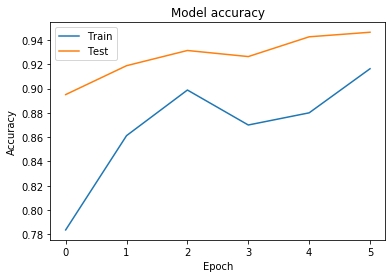

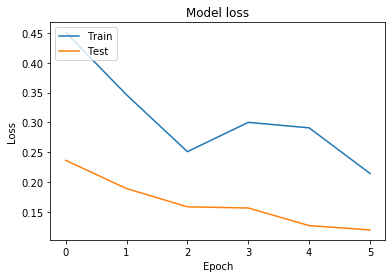

In [12]:
model3 = new_model(n=1024, dropout=0, pooling='max')
train(model3, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params2(lr=0.0001),
      layer_count=2,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model3, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params2(lr=0.00001),
      layer_count=19,
      epochs=6,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))

## Model 4
Trying dropout.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/8
100/100 [==============================] - 16s 162ms/step - loss: 0.4561 - acc: 0.8500 - val_loss: 0.0828 - val_acc: 0.9688
Epoch 2/8
100/100 [==============================] - 15s 146ms/step - loss: 0.5411 - acc: 0.8450 - val_loss: 0.2388 - val_acc: 0.9125
Epoch 3/8
100/100 [==============================] - 15s 145ms/step - loss: 0.3450 - acc: 0.8800 - val_loss: 0.1490 - val_acc: 0.9475
Epoch 4/8
100/100 [==============================] - 14s 143ms/step - loss: 0.2597 - acc: 0.9100 - val_loss: 0.1159 - val_acc: 0.9525
Epoch 5/8
100/100 [==============================] - 14s 138ms/step - loss: 0.3020 - acc: 0.8925 - val_loss: 0.0644 - val_acc: 0.9725
Epoch 6/8
100/100 [==============================] - 14s 136ms/step - loss: 0.2909 - acc: 0.8825 - val_loss: 0.0719 - val_acc: 0.971

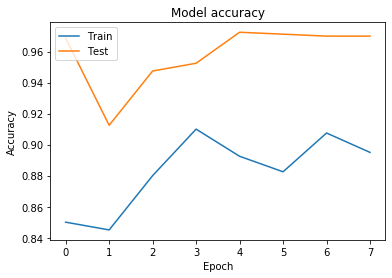

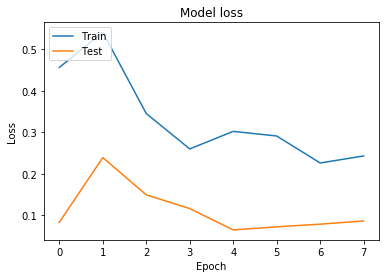

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 19s 194ms/step - loss: 0.1579 - acc: 0.9313 - val_loss: 0.0671 - val_acc: 0.9725
Epoch 2/4
100/100 [==============================] - 17s 167ms/step - loss: 0.1681 - acc: 0.9325 - val_loss: 0.0600 - val_acc: 0.9762
Epoch 3/4
100/100 [==============================] - 18s 183ms/step - loss: 0.2114 - acc: 0.9250 - val_loss: 0.0593 - val_acc: 0.9762
Epoch 4/4
100/100 [==============================] - 17s 174ms/step - loss: 0.1839 - acc: 0.9262 - val_loss: 0.0669 - val_acc: 0.9750


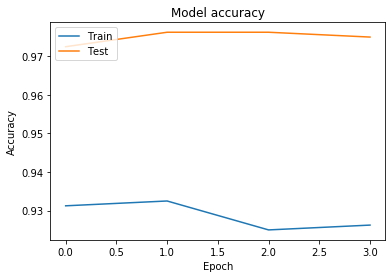

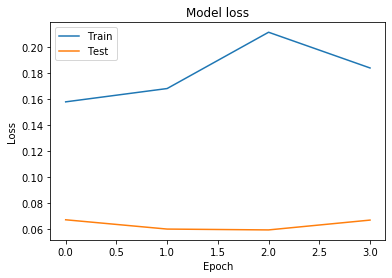

In [13]:
model4 = new_model(dropout=0.5)
train(model4, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params2(decay=0.001),
      layer_count=3,
      epochs=8,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model4, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params2(lr=0.00003),
      layer_count=20,
      epochs=4,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))

## Models 5 and 6: smaller FCL

Creating the model
Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/8
100/100 [==============================] - 16s 163ms/step - loss: 0.4253 - acc: 0.8125 - val_loss: 0.1142 - val_acc: 0.9525
Epoch 2/8
100/100 [==============================] - 14s 137ms/step - loss: 0.2607 - acc: 0.8900 - val_loss: 0.0837 - val_acc: 0.9675
Epoch 3/8
100/100 [==============================] - 13s 135ms/step - loss: 0.2939 - acc: 0.8637 - val_loss: 0.0818 - val_acc: 0.9688
Epoch 4/8
100/100 [==============================] - 14s 136ms/step - loss: 0.2329 - acc: 0.9025 - val_loss: 0.0782 - val_acc: 0.9663
Epoch 5/8
100/100 [==============================] - 13s 135ms/step - loss: 0.2548 - acc: 0.8937 - val_loss: 0.0925 - val_acc: 0.9637
Epoch 6/8
100/100 [==============================] - 14s 136ms/step - loss: 0.2314 - acc: 0.9000 - val_loss: 0.1359 - val_acc: 0.9425
Epoch 7/8
100/100 [==============================] - 13s 132ms/step - loss: 0.2070 - acc: 0.92

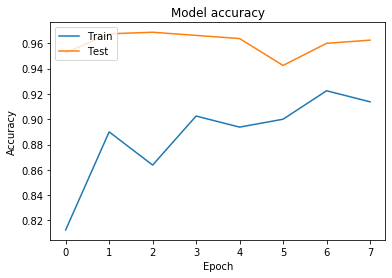

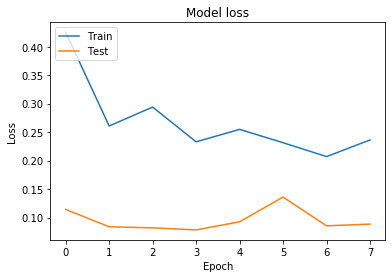

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 20s 199ms/step - loss: 0.2135 - acc: 0.8975 - val_loss: 0.0716 - val_acc: 0.9663
Epoch 2/4
100/100 [==============================] - 18s 178ms/step - loss: 0.2098 - acc: 0.9150 - val_loss: 0.0653 - val_acc: 0.9712
Epoch 3/4
100/100 [==============================] - 17s 172ms/step - loss: 0.1856 - acc: 0.9262 - val_loss: 0.0616 - val_acc: 0.9750
Epoch 4/4
100/100 [==============================] - 17s 174ms/step - loss: 0.1918 - acc: 0.9237 - val_loss: 0.0617 - val_acc: 0.9788


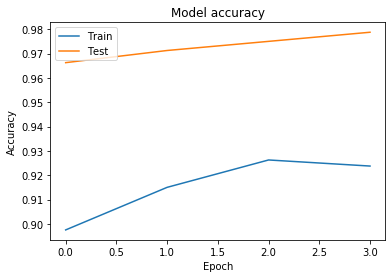

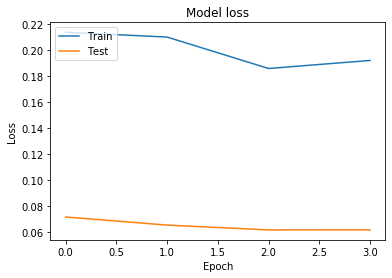

In [15]:
print("Creating the model")
model5 = new_model(n=256, dropout=0.5, pooling='avg')
train(model5, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params2(decay=0.001),
      layer_count=3,
      epochs=8,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model5, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params2(lr=0.00003),
      layer_count=20,
      epochs=4,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))


With a smaller FCL max pooling is all right

Creating the model
Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/8
100/100 [==============================] - 17s 166ms/step - loss: 1.2834 - acc: 0.7463 - val_loss: 0.2402 - val_acc: 0.9225
Epoch 2/8
100/100 [==============================] - 14s 137ms/step - loss: 0.6044 - acc: 0.8275 - val_loss: 0.2763 - val_acc: 0.9062
Epoch 3/8
100/100 [==============================] - 13s 134ms/step - loss: 0.3673 - acc: 0.8575 - val_loss: 0.0869 - val_acc: 0.9650
Epoch 4/8
100/100 [==============================] - 13s 135ms/step - loss: 0.2938 - acc: 0.8850 - val_loss: 0.3366 - val_acc: 0.8575
Epoch 5/8
100/100 [==============================] - 14s 136ms/step - loss: 0.3020 - acc: 0.8662 - val_loss: 0.0964 - val_acc: 0.9650
Epoch 6/8
100/100 [==============================] - 13s 133ms/step - loss: 0.3627 - acc: 0.8438 - val_loss: 0.0920 - val_acc: 0.9675
Epoch 7/8
100/100 [==============================] - 14s 138ms/step - loss: 0.2719 - acc: 0.88

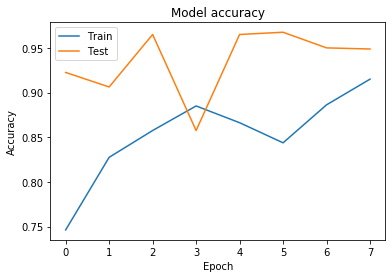

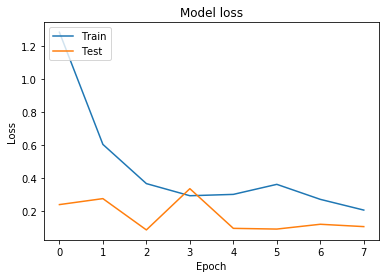

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 21s 205ms/step - loss: 0.1841 - acc: 0.9350 - val_loss: 0.0649 - val_acc: 0.9762
Epoch 2/4
100/100 [==============================] - 17s 173ms/step - loss: 0.1948 - acc: 0.9087 - val_loss: 0.0588 - val_acc: 0.9788
Epoch 3/4
100/100 [==============================] - 17s 171ms/step - loss: 0.2454 - acc: 0.9025 - val_loss: 0.0650 - val_acc: 0.9738
Epoch 4/4
100/100 [==============================] - 17s 168ms/step - loss: 0.2342 - acc: 0.9163 - val_loss: 0.0602 - val_acc: 0.9825


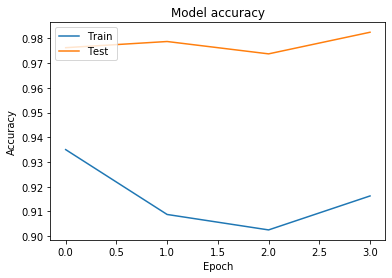

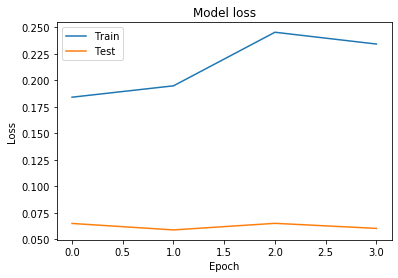

In [17]:
print("Creating the model")
model6 = new_model(n=256, dropout=0.5, pooling='max')
train(model6, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=dense_params2(decay=0.001),
      layer_count=3,
      epochs=8,
      validation_directory=os.path.join(DATA_ROOT, 'part2'),
      validation_generator=dg_val)
train(model6, dg_train, os.path.join(DATA_ROOT, 'part1'),
      params=base_params2(lr=0.00003),
      layer_count=20,
      epochs=4,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part2'))


Swapping the training & evaluation data with zero dropout just to observe higher test accuracy once again.  I can't account for that.

Creating the model
Found 800 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 44s 444ms/step - loss: 1.2282 - acc: 0.7887 - val_loss: 0.1664 - val_acc: 0.9515
Epoch 2/4
100/100 [==============================] - 40s 402ms/step - loss: 0.5493 - acc: 0.8650 - val_loss: 0.2965 - val_acc: 0.9130
Epoch 3/4
100/100 [==============================] - 42s 416ms/step - loss: 0.3939 - acc: 0.8775 - val_loss: 0.1162 - val_acc: 0.9555
Epoch 4/4
100/100 [==============================] - 42s 421ms/step - loss: 0.2561 - acc: 0.9025 - val_loss: 0.1163 - val_acc: 0.9547


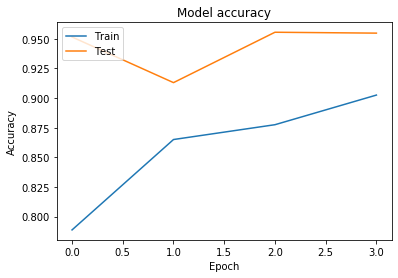

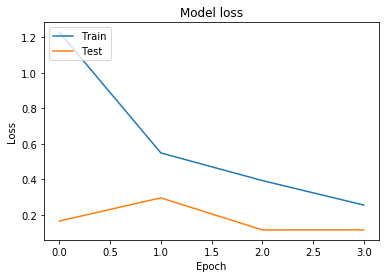

Found 800 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 51s 508ms/step - loss: 0.1225 - acc: 0.9525 - val_loss: 0.0947 - val_acc: 0.9650
Epoch 2/4
100/100 [==============================] - 44s 438ms/step - loss: 0.1237 - acc: 0.9500 - val_loss: 0.0913 - val_acc: 0.9660
Epoch 3/4
100/100 [==============================] - 47s 471ms/step - loss: 0.1036 - acc: 0.9575 - val_loss: 0.0952 - val_acc: 0.9625
Epoch 4/4
100/100 [==============================] - 47s 467ms/step - loss: 0.1154 - acc: 0.9575 - val_loss: 0.0891 - val_acc: 0.9643


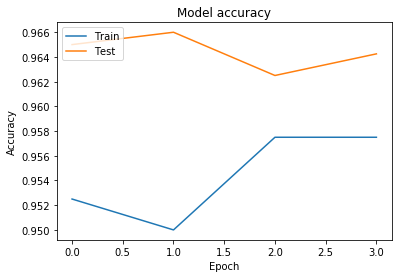

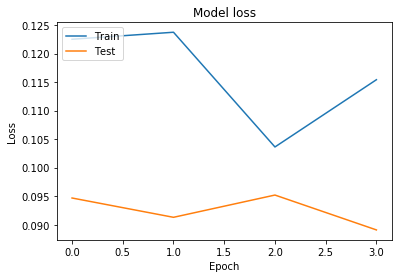

In [25]:
print("Creating the model")
model7 = new_model(n=256, dropout=0, pooling='max')
train(model7, dg_train, os.path.join(DATA_ROOT, 'part2'),
      params=dense_params2(),
      layer_count=3,
      epochs=4,
      validation_directory=os.path.join(DATA_ROOT, 'part1'),
      validation_generator=dg_val)
train(model7, dg_train, os.path.join(DATA_ROOT, 'part2'),
      params=base_params2(lr=0.00003),
      layer_count=20,
      epochs=4,
      validation_generator=dg_val,
      validation_directory=os.path.join(DATA_ROOT, 'part1'))